# Connecting NDVI, Groundwater, and Stream Disconnection During Drought: Case Study along the Rio Grande
Danielle Tadych
Revised Notebook 8/2023

This notebook is to expand upon our analysis from the Data challenge but to include more sophisticated data collection and analysis techniques.

For the previous report, see DataChallengeReport_RioGrandeAnalysis.ipynb.

In order to run this code, you need to have downloaded scenes from "Making_An_Order.ipynb".

## Full Analysis Code

This section starts the process of an order

In [2]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import json
import requests
import time
from requests.auth import HTTPBasicAuth
from osgeo import gdal
import subprocess
import datetime
import xarray as xr
import rioxarray as rxr
import pandas as pd
import geopandas as gp
import pathlib
from planet import Session, DataClient, OrdersClient
import geojsonio
import shutil
import rasterio.plot as show
import rasterio
print("packages loaded.")

packages loaded.


### Mosaicing for all of Rio Grande

In [15]:
# Get meta data on the raster images
# !gdalinfo ~/Documents/PhD_Materials/github_repos/Tadych_PlanetData_Challenge/Data/RapidEye/1354105_2010-03-25_RE5_3A_Analytic_SR_clip.tif

Driver: GTiff/GeoTIFF
Files: /Users/danielletadych/Documents/PhD_Materials/github_repos/Tadych_PlanetData_Challenge/Data/RapidEye/1354105_2010-03-25_RE5_3A_Analytic_SR_clip.tif
       /Users/danielletadych/Documents/PhD_Materials/github_repos/Tadych_PlanetData_Challenge/Data/RapidEye/1354105_2010-03-25_RE5_3A_Analytic_SR_clip.tif.aux.xml
Size is 248, 309
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 13N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 13N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-105,
            ANGLEUNIT["degree

In [10]:
# Get meta data on the raster images
!gdalinfo ~/Documents/PhD_Materials/github_repos/Tadych_PlanetData_Challenge/Data/AllRioGrande/All_RioGrande_MayApr2021_psscene_analytic_sr_udm2/PSScene/20210419_144351_1050_3B_udm2_clip.tif

Driver: GTiff/GeoTIFF
Files: /Users/danielletadych/Documents/PhD_Materials/github_repos/Tadych_PlanetData_Challenge/Data/AllRioGrande/All_RioGrande_MayApr2021_psscene_analytic_sr_udm2/PSScene/20210419_144351_1050_3B_udm2_clip.tif
Size is 2066, 3813
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 13N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 13N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-105,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.99

##### Show all the downloaded Rapid Eye files

In [202]:
# ls Data/RapidEye/*RE*_3A_Analytic_SR_clip.tif

##### Show all the downloaded Planet Scope files

In [203]:
# ls Data/PlanetScope/*SR_clip.tif

In [206]:
# for i in years:
#     year = str(i)
#     for j in months:
#         # month = str(j)
#         month = format(j, '02')
#         for k in days:
#             day = format(k, '02')
#             print(year+"-"+month+"-"+day)

In [204]:

# ls -1 Data/RapidEye/*RE*_3A_Analytic_SR_clip.tif > tiff_test_list.txt


In [2]:
# items = glob.glob('Data/RapidEye/*2010*RE*_3A_Analytic_SR_clip.tif')
# site_name = 'MES_48R'
site_name = 'All_RioGrande_MayApr2021_psscene_analytic_sr_udm2'
# file_loc = 'data/'+site_name+'/files/'
file_loc = 'data/AllRioGrande/'+site_name+'/PSScene/'
items = glob.glob(file_loc+'*Analytic*.tif')

items.sort()
items

['data/AllRioGrande/All_RioGrande_MayApr2021_psscene_analytic_sr_udm2/PSScene/20210419_144345_1050_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data/AllRioGrande/All_RioGrande_MayApr2021_psscene_analytic_sr_udm2/PSScene/20210419_144346_1050_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data/AllRioGrande/All_RioGrande_MayApr2021_psscene_analytic_sr_udm2/PSScene/20210419_144347_1050_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data/AllRioGrande/All_RioGrande_MayApr2021_psscene_analytic_sr_udm2/PSScene/20210419_144348_1050_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data/AllRioGrande/All_RioGrande_MayApr2021_psscene_analytic_sr_udm2/PSScene/20210419_144349_1050_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data/AllRioGrande/All_RioGrande_MayApr2021_psscene_analytic_sr_udm2/PSScene/20210419_144350_1050_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data/AllRioGrande/All_RioGrande_MayApr2021_psscene_analytic_sr_udm2/PSScene/20210419_144351_1050_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data/AllRioGrande/All_RioGrande_

In [3]:
# Getting the date ranges
years = range(2010,2024)
months = range(1,13)
days = range(0,32)

# Use this to make it stop printing that there aren't images available
gdal.PushErrorHandler('CPLQuietErrorHandler')

# Mosaicing for loop for Both Rapid Eye and PS at the same time
for i in years:
    year = str(i)
    for j in months:
        # month = str(j)
        month = format(j, '02')
        for k in days:
            day = format(k, '02')
            # print(year+"-"+month+"-"+day) #Un-comment this if you want to see which days hve errors
            monthly_files_list = glob.glob(file_loc+'*'+year+"-"+month+"-"+day+'*SR*.tif')
            # This code was for writing all the files into a text file
            # with open(year+'-'+month+'_tif_list.txt', 'w') as f:
            #     for line in items:
            #         f.write(line)
            #         f.write('\n')
            files_to_mosaic = monthly_files_list # However many you want.
            # g = gdal.Warp('outputfiles/MES_48R/mosaic_'+year+'-'+month+"-"+day+'.tif', files_to_mosaic, format="GTiff",
            g = gdal.Warp('outputfiles/AllRioGrande/mosaic_'+year+'-'+month+"-"+day+'.tif', files_to_mosaic, format="GTiff",
                  options=["COMPRESS=LZW", "TILED=YES"]) # if you want
            g = None # Close file and flush to disk
            # !gdal_merge.py -n 0 -v -o 'mosaic_year'+'-'+month+'_test.tif' --optfile year+'-'+month+'2010_tif_list.txt'
    print('Finished for ',year)

Finished for  2010
Finished for  2011
Finished for  2012
Finished for  2013
Finished for  2014
Finished for  2015
Finished for  2016
Finished for  2017
Finished for  2018
Finished for  2019
Finished for  2020
Finished for  2021
Finished for  2022
Finished for  2023


This block is for handling if the filenames are different.  For the new image ID naming convention, run this one.

In [4]:
# Getting the date ranges
years = range(2010,2024)
months = range(1,13)
days = range(0,32)

# Use this to make it stop printing that there aren't images available
gdal.PushErrorHandler('CPLQuietErrorHandler')

# Mosaicing for loop for Both Rapid Eye and PS at the same time
for i in years:
    year = str(i)
    for j in months:
        # month = str(j)
        month = format(j, '02')
        for k in days:
            day = format(k, '02')
            # print(year+"-"+month+"-"+day) #Un-comment this if you want to see which days hve errors
            monthly_files_list = glob.glob(file_loc+'*'+year+month+day+'*MS*.tif')
            # This code was for writing all the files into a text file
            # with open(year+'-'+month+'_tif_list.txt', 'w') as f:
            #     for line in items:
            #         f.write(line)
            #         f.write('\n')
            files_to_mosaic = monthly_files_list # However many you want.
            # g = gdal.Warp('outputfiles/MES_48R/mosaic_'+year+'-'+month+"-"+day+'.tif', files_to_mosaic, format="GTiff",
            g = gdal.Warp('outputfiles/AllRioGrande/mosaic_'+year+'-'+month+"-"+day+'.tif', files_to_mosaic, format="GTiff",
                  options=["COMPRESS=LZW", "TILED=YES"]) # if you want
            g = None # Close file and flush to disk
            # !gdal_merge.py -n 0 -v -o 'mosaic_year'+'-'+month+'_test.tif' --optfile year+'-'+month+'2010_tif_list.txt'
    print('Finished for ',year)

Finished for  2010
Finished for  2011
Finished for  2012
Finished for  2013
Finished for  2014
Finished for  2015
Finished for  2016
Finished for  2017
Finished for  2018
Finished for  2019
Finished for  2020


### Extract the data from the red and near-infrared bands 

In [14]:
import rasterio
import numpy as np

# filepath = "outputfiles/MES_48R/"
filepath = 'outputfiles/AllRioGrande/'
outputpath = 'outputfiles/ndvi/AllRioGrande/'
# filename = "data/20160831_180302_0e26_3B_AnalyticMS_SR.tif"
# filename = filepath+"1354107_2013-05-19_RE2_3A_Analytic_SR_clip.tif"
# filename = '2013-05-19_merged.tif'
# filename = 'mosaic_2019-03-15.tif'
filename = 'mosaic_2021-05-07.tif'

# Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
with rasterio.open(filepath+filename) as src:
    band_red = src.read(3)

with rasterio.open(filepath+filename) as src:
    band_nir = src.read(4)

### Perform the NDVI calculation

Next, you're going to calculate NDVI through subtraction and division of the values stored in the NumPy arrays. This calculation will give you NDVI values that range from -1 to 1. Values closer to 1 indicate a greater density of vegetation or higher level of "greenness."

In [15]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

In [16]:
ndvi

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.09155121, 0.09006041,
        0.0996732 ],
       [       nan,        nan,        nan, ..., 0.10862023, 0.10595303,
        0.09466153],
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.09274414]])

In [17]:
rivermin = 0
# ndvi_blocked = ndvi[ndvi>=rivermin]
ndvi_blocked = ndvi.astype('float')
ndvi_blocked[ndvi_blocked <=rivermin] = 'nan'
ndvi_blocked

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.09155121, 0.09006041,
        0.0996732 ],
       [       nan,        nan,        nan, ..., 0.10862023, 0.10595303,
        0.09466153],
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.09274414]])

In [18]:
# check range NDVI values, excluding NaN
np.nanmin(ndvi_blocked), np.nanmax(ndvi_blocked)

(7.649353629618297e-05, 0.93613496008435)

In [19]:
# If the above looks correctly, run this
ndvi = ndvi_blocked

### Save an NDVI image 

Next, you're going to save the calculated NDVI values to a new image file, making sure the new image file has the same geospatial metadata as the original GeoTIFF we downloaded.

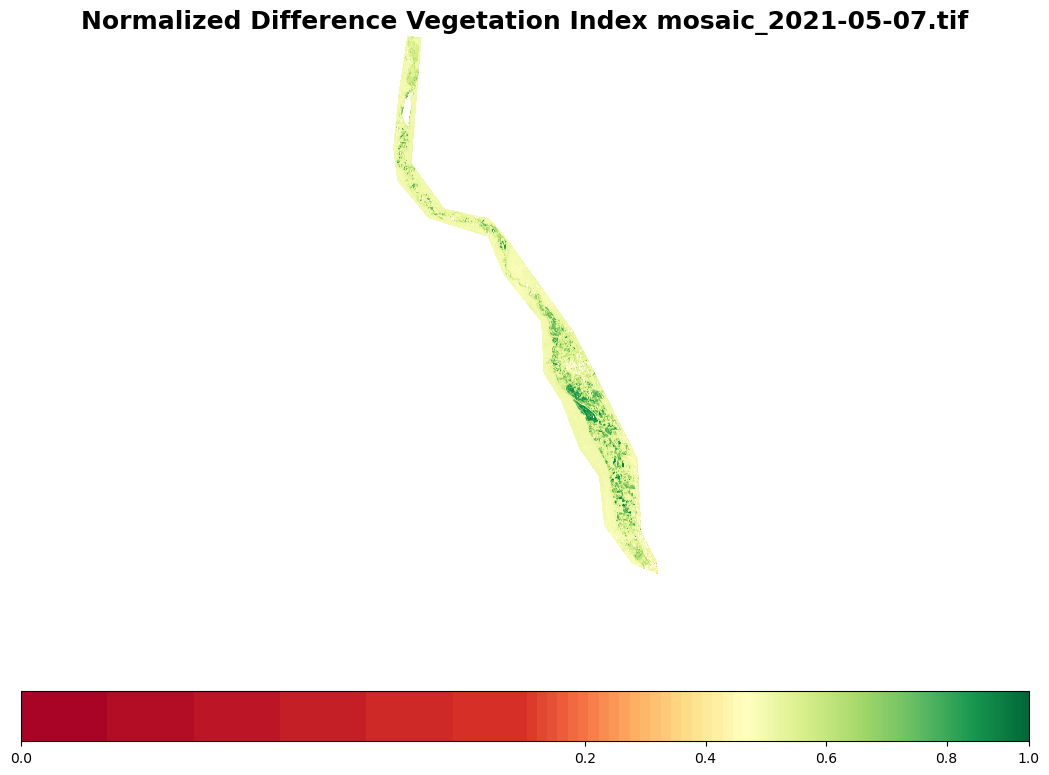

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

"""
The NDVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Normalized Difference Vegetation Index '+str(filename), fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

fig.savefig(outputpath+filename+"ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

In [21]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open(outputpath+filename+'_ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

Now to perform the calculation for multiple files at once in a smaller study area

First create a list of all the ndvi files

In [2]:
outputpath = 'outputfiles/MES_48R/ndvi/'
# items = glob.glob('outputfiles/MES_48R/*.tif')
items = glob.glob('outputfiles/MES_48R/*.tif')
items.sort()
items

['outputfiles/MES_48R/mosaic_2016-01-11.tif',
 'outputfiles/MES_48R/mosaic_2016-01-24.tif',
 'outputfiles/MES_48R/mosaic_2016-02-04.tif',
 'outputfiles/MES_48R/mosaic_2016-02-10.tif',
 'outputfiles/MES_48R/mosaic_2016-02-15.tif',
 'outputfiles/MES_48R/mosaic_2016-02-28.tif',
 'outputfiles/MES_48R/mosaic_2016-03-02.tif',
 'outputfiles/MES_48R/mosaic_2016-04-10.tif',
 'outputfiles/MES_48R/mosaic_2016-04-30.tif',
 'outputfiles/MES_48R/mosaic_2016-06-06.tif',
 'outputfiles/MES_48R/mosaic_2016-07-09.tif',
 'outputfiles/MES_48R/mosaic_2016-07-23.tif',
 'outputfiles/MES_48R/mosaic_2017-01-31.tif',
 'outputfiles/MES_48R/mosaic_2017-02-05.tif',
 'outputfiles/MES_48R/mosaic_2017-02-25.tif',
 'outputfiles/MES_48R/mosaic_2017-03-08.tif',
 'outputfiles/MES_48R/mosaic_2017-03-12.tif',
 'outputfiles/MES_48R/mosaic_2017-04-21.tif',
 'outputfiles/MES_48R/mosaic_2017-05-02.tif',
 'outputfiles/MES_48R/mosaic_2017-05-17.tif',
 'outputfiles/MES_48R/mosaic_2017-05-20.tif',
 'outputfiles/MES_48R/mosaic_2017-

In [3]:
years = range(2010,2023)
for y in years:
    year = str(y)
    yearcount = glob.glob('outputfiles/MES_48R/*'+year+'*.tif')
    print(year,':',len(yearcount))

2010 : 0
2011 : 0
2012 : 0
2013 : 0
2014 : 0
2015 : 0
2016 : 12
2017 : 20
2018 : 65
2019 : 106
2020 : 229
2021 : 202
2022 : 196


In [7]:
# Change this based on what minimum to set for the streambed
rivermin = 0

In [8]:
# For loop to standardize this

for i in items:
    mosaic = i
    # Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
    with rasterio.open(mosaic) as src:
        band_red = src.read(3)
    with rasterio.open(mosaic) as src:
        band_nir = src.read(4)
    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')
    # Calculate NDVI. This is the equation at the top of this guide expressed in code
    ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)# check range NDVI values, excluding NaN
    ndvi_blocked = ndvi.astype('float')
    ndvi_blocked[ndvi_blocked <=rivermin] = 'nan'
    ndvi = ndvi_blocked
    np.nanmin(ndvi), np.nanmax(ndvi)
    date = i[-14:-4]
    # Set spatial characteristics of the output object to mirror the input
    kwargs = src.meta
    kwargs.update(
        dtype=rasterio.float32,
        count = 1)

    # Write band calculations to a new raster file
    with rasterio.open(outputpath+date+'_ndvi.tif', 'w', **kwargs) as dst:
            dst.write_band(1, ndvi.astype(rasterio.float32))

print("NDVI files exported.")

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_3846/847216218.py:17: RuntimeWarning: All-NaN slice encountered
  np.nanmin(ndvi), np.nanmax(ndvi)


NDVI files exported.


### Visualize the NDVI values on the image

In the last two steps, you'll use [Matplotlib](https://matplotlib.org/) to visualize the NDVI values you calculated for the PlanetScope scene. First you'll view a map of the NDVI values; then you'll generate a histogram of NDVI values. 

### Generate a histogram of NDVI values

NameError: name 'filename' is not defined

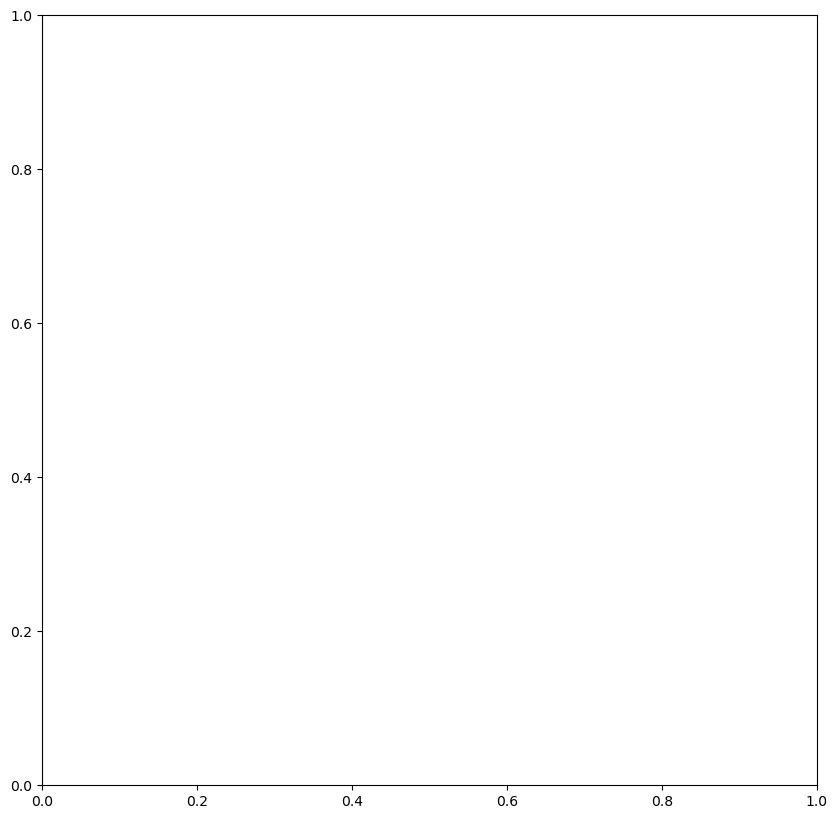

In [9]:
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title(str(filename)+" NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = ndvi[~np.isnan(ndvi)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)

fig2.savefig(outputpath+filename+" ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

## Creating a time indexed dataframe

In [3]:
site_name = 'MES_48R'

<Axes: >

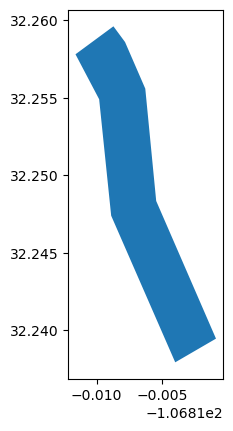

In [4]:
# Read in the Shapefile
filename = 'AOI/'+site_name+'_simplified.shp'
# filepath = os.path.join('Data/Shapefiles/', filename)
# filepath = os.path.join('Data/Shapefiles/', filename)
study_areas = gp.read_file(filename)
study_areas.plot()

In [5]:
# Open in xarray

ndvi_tifs = glob.glob('outputfiles/MES_48R/ndvi/*ndvi.tif')
ndvi_tifs.sort()
ndvi_tifs

['outputfiles/MES_48R/ndvi/2016-01-11_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2016-01-24_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2016-02-04_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2016-02-10_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2016-02-15_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2016-02-28_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2016-03-02_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2016-04-10_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2016-04-30_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2016-06-06_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2016-07-09_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2016-07-23_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2017-01-31_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2017-02-05_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2017-02-25_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2017-03-08_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2017-03-12_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2017-04-21_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2017-05-02_ndvi.tif',
 'outputfiles/MES_48R/ndvi/2017-05-17_ndvi.tif',
 'outputfiles/MES_48

In [6]:
date_list = []
for i in ndvi_tifs:
    print(i)
    # date = i[-14:-4]
    date = i[-19:-9]
    parsed_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    date_list.append(parsed_date)
dt_array = np.array(date_list, dtype='datetime64')
dt_array.sort()

outputfiles/MES_48R/ndvi/2016-01-11_ndvi.tif
outputfiles/MES_48R/ndvi/2016-01-24_ndvi.tif
outputfiles/MES_48R/ndvi/2016-02-04_ndvi.tif
outputfiles/MES_48R/ndvi/2016-02-10_ndvi.tif
outputfiles/MES_48R/ndvi/2016-02-15_ndvi.tif
outputfiles/MES_48R/ndvi/2016-02-28_ndvi.tif
outputfiles/MES_48R/ndvi/2016-03-02_ndvi.tif
outputfiles/MES_48R/ndvi/2016-04-10_ndvi.tif
outputfiles/MES_48R/ndvi/2016-04-30_ndvi.tif
outputfiles/MES_48R/ndvi/2016-06-06_ndvi.tif
outputfiles/MES_48R/ndvi/2016-07-09_ndvi.tif
outputfiles/MES_48R/ndvi/2016-07-23_ndvi.tif
outputfiles/MES_48R/ndvi/2017-01-31_ndvi.tif
outputfiles/MES_48R/ndvi/2017-02-05_ndvi.tif
outputfiles/MES_48R/ndvi/2017-02-25_ndvi.tif
outputfiles/MES_48R/ndvi/2017-03-08_ndvi.tif
outputfiles/MES_48R/ndvi/2017-03-12_ndvi.tif
outputfiles/MES_48R/ndvi/2017-04-21_ndvi.tif
outputfiles/MES_48R/ndvi/2017-05-02_ndvi.tif
outputfiles/MES_48R/ndvi/2017-05-17_ndvi.tif
outputfiles/MES_48R/ndvi/2017-05-20_ndvi.tif
outputfiles/MES_48R/ndvi/2017-05-26_ndvi.tif
outputfile

In [7]:
dt_array

array(['2016-01-11T00:00:00.000000', '2016-01-24T00:00:00.000000',
       '2016-02-04T00:00:00.000000', '2016-02-10T00:00:00.000000',
       '2016-02-15T00:00:00.000000', '2016-02-28T00:00:00.000000',
       '2016-03-02T00:00:00.000000', '2016-04-10T00:00:00.000000',
       '2016-04-30T00:00:00.000000', '2016-06-06T00:00:00.000000',
       '2016-07-09T00:00:00.000000', '2016-07-23T00:00:00.000000',
       '2017-01-31T00:00:00.000000', '2017-02-05T00:00:00.000000',
       '2017-02-25T00:00:00.000000', '2017-03-08T00:00:00.000000',
       '2017-03-12T00:00:00.000000', '2017-04-21T00:00:00.000000',
       '2017-05-02T00:00:00.000000', '2017-05-17T00:00:00.000000',
       '2017-05-20T00:00:00.000000', '2017-05-26T00:00:00.000000',
       '2017-06-25T00:00:00.000000', '2017-06-30T00:00:00.000000',
       '2017-09-17T00:00:00.000000', '2017-09-22T00:00:00.000000',
       '2017-10-17T00:00:00.000000', '2017-10-28T00:00:00.000000',
       '2017-11-05T00:00:00.000000', '2017-11-26T00:00:00.0000

Print the Number of maps or days we have

In [8]:
len(ndvi_tifs)

993

In [9]:
# Testing to see if coordinate systems match
test_case = ndvi_tifs[0]
print(test_case)
ndvi_file_toclip = xr.open_dataset(test_case)
mask = study_areas
print("mask crs:", mask.crs)
print("data crs:", ndvi_file_toclip.rio.crs)
ndvi_file_toclip_array = ndvi_file_toclip['band_data'].to_numpy()
ndvi_file_toclip_array.shape

outputfiles/MES_48R/ndvi/2016-01-11_ndvi.tif
mask crs: EPSG:4326
data crs: EPSG:32613


(1, 483, 196)

Note 9/22 - the issue is each image changes resolutions.  Try interpolating each before converting to numpy following this tutorial:
https://stackoverflow.com/questions/63189798/change-resolution-of-one-dataarray-to-match-another

In [10]:
test_ndvifile_highres = xr.open_dataset(ndvi_tifs[157])
test_ndvifile_lowres = xr.open_dataset(ndvi_tifs[0])

In [11]:
test_ndvifile_lowres

<xarray.Dataset>
Dimensions:      (band: 1, x: 196, y: 483)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.284e+05 3.284e+05 ... 3.294e+05 3.294e+05
  * y            (y) float64 3.571e+06 3.571e+06 ... 3.568e+06 3.568e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [12]:
test_ndvifile_highres

<xarray.Dataset>
Dimensions:      (band: 1, x: 326, y: 804)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.284e+05 3.284e+05 ... 3.294e+05 3.294e+05
  * y            (y) float64 3.571e+06 3.571e+06 ... 3.568e+06 3.568e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [13]:
da1 = test_ndvifile_lowres
da2 = test_ndvifile_highres
new_x = np.linspace(da1.x[0], da1.x[-1], da2.sizes['x'])
new_y = np.linspace(da1.y[0], da1.y[-1], da2.sizes['y'])
da1_interpolated = da1.interp(y = new_y, x = new_x)
da1_interpolated



<xarray.Dataset>
Dimensions:      (band: 1, y: 804, x: 326)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * y            (y) float64 3.571e+06 3.571e+06 ... 3.568e+06 3.568e+06
  * x            (x) float64 3.284e+05 3.284e+05 ... 3.294e+05 3.294e+05
Data variables:
    band_data    (band, y, x) float64 nan nan nan nan nan ... nan nan nan nan

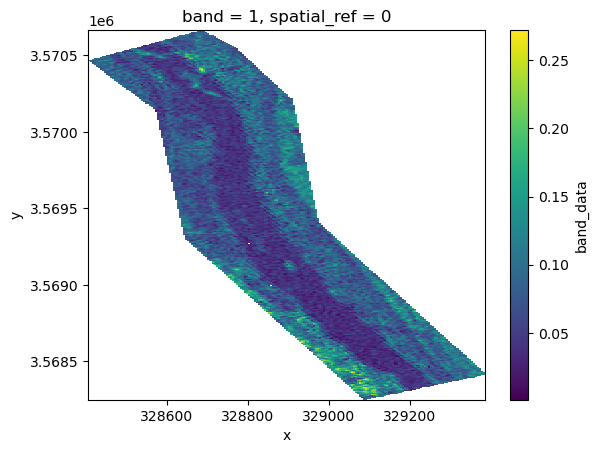

In [14]:
ndvi_file_toclip['band_data'].plot()

In [15]:
# Skip this if they are both in the same coordinate system and change info in next cell
mask_reproject = mask.to_crs(epsg=32613)
print("mask crs:", mask_reproject.crs)

mask crs: EPSG:32613


<Axes: >

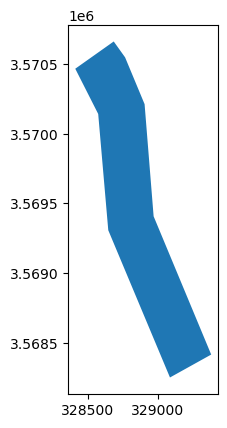

In [16]:
mask_reproject.plot()

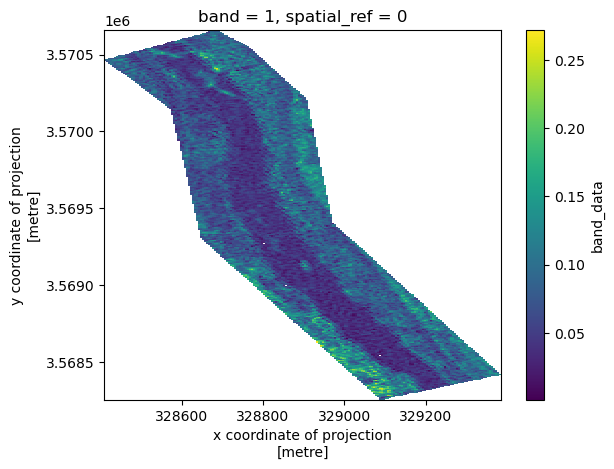

In [17]:
# Clipping
clipped = ndvi_file_toclip.rio.clip(mask_reproject.geometry, mask_reproject.crs)
clipped['band_data'].plot()

In [18]:
clipped_np = clipped['band_data'].to_numpy()
clipped_np.shape

(1, 481, 195)

This interpolates all the tifs and makes sure to only clip the areas we want

In [19]:
test_ndvifile_highres = xr.open_dataset(ndvi_tifs[-1])
all_data = []
for i in range(0,len(ndvi_tifs),1):
    print(ndvi_tifs[i])
    ndvi_file = xr.open_dataset(ndvi_tifs[i])
   
    clipped = ndvi_file.rio.clip(mask_reproject.geometry, mask_reproject.crs)

    da1 = clipped
    da2 = test_ndvifile_highres
    new_x = np.linspace(da1.x[0], da1.x[-1], da2.sizes['x'])
    new_y = np.linspace(da1.y[0], da1.y[-1], da2.sizes['y'])
    da1_interpolated = da1.interp(y = new_y, x = new_x)

    ndvi_data = da1_interpolated['band_data']
    
    # ndvi_data = ndvi_file['band_data']
    
    ndvi_array = ndvi_data.to_numpy()
    
    # also_array = np.pad(ndvi_array.astype(float),(0,483*196- ndvi_array.size), mode='constant',constant_values=np.nan).reshape(1,483,196)

    # also_array.shape
    # ndvi_array = ndvi_file['band_data'].to_numpy()
    # print(type(ndvi_array))

    # # dummy_array = np.ndarray(shape=ndvi_array_1,dtype=float)
    # # ndvi_array.read.direct(dummy_array)
    # # np.place(dummy_array, dummy_array==ndvi_array.attrs.get('_FillValue'),np.nan)
    # ndvi_array=np.ndarray(shape=ndvi_data.shape,dtype=float)
    # ndvi_data.read_direct(ndvi_array)
    # np.place(ndvi_array,ndvi_array==ndvi_data.attrs.get('_FillValue'), np.nan)
    all_data.append(ndvi_array)
    
    # print(ndvi_array.shape)
    
    # all_data.append(ndvi_file)
all_data

outputfiles/MES_48R/ndvi/2016-01-11_ndvi.tif
outputfiles/MES_48R/ndvi/2016-01-24_ndvi.tif
outputfiles/MES_48R/ndvi/2016-02-04_ndvi.tif
outputfiles/MES_48R/ndvi/2016-02-10_ndvi.tif
outputfiles/MES_48R/ndvi/2016-02-15_ndvi.tif
outputfiles/MES_48R/ndvi/2016-02-28_ndvi.tif
outputfiles/MES_48R/ndvi/2016-03-02_ndvi.tif
outputfiles/MES_48R/ndvi/2016-04-10_ndvi.tif
outputfiles/MES_48R/ndvi/2016-04-30_ndvi.tif
outputfiles/MES_48R/ndvi/2016-06-06_ndvi.tif
outputfiles/MES_48R/ndvi/2016-07-09_ndvi.tif
outputfiles/MES_48R/ndvi/2016-07-23_ndvi.tif
outputfiles/MES_48R/ndvi/2017-01-31_ndvi.tif
outputfiles/MES_48R/ndvi/2017-02-05_ndvi.tif
outputfiles/MES_48R/ndvi/2017-02-25_ndvi.tif
outputfiles/MES_48R/ndvi/2017-03-08_ndvi.tif
outputfiles/MES_48R/ndvi/2017-03-12_ndvi.tif
outputfiles/MES_48R/ndvi/2017-04-21_ndvi.tif
outputfiles/MES_48R/ndvi/2017-05-02_ndvi.tif
outputfiles/MES_48R/ndvi/2017-05-17_ndvi.tif
outputfiles/MES_48R/ndvi/2017-05-20_ndvi.tif
outputfiles/MES_48R/ndvi/2017-05-26_ndvi.tif
outputfile

[array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]),
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]),
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]),
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ...,

In [20]:
combo = np.vstack(all_data)
combo.shape

(993, 804, 326)

In [21]:
lat_main = test_ndvifile_highres['x']
lon_main = test_ndvifile_highres['y']

lon_main = lon_main.to_numpy()
lat_main = lat_main.to_numpy()
# lat_main

In [22]:
print("Main data shape: ", combo.shape)
print('Longitude shape: ', lon_main.shape)
print("Latitude shape: ", lat_main.shape)
print('Data Shape: ', dt_array.shape)

Main data shape:  (993, 804, 326)
Longitude shape:  (804,)
Latitude shape:  (326,)
Data Shape:  (993,)


Creating the x-array

In [23]:
data_xr = xr.DataArray(
    combo,
    coords={'time':dt_array,'lon': lon_main,'lat': lat_main}, 
    dims=["time","lon", "lat"],
    attrs=dict(
        description="Calculated NDVI")
)
data_xr

<xarray.DataArray (time: 993, lon: 804, lat: 326)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-11 2016-01-24 ... 2023-10-08
  * lon      (lon) float64 3.571e+06 3.571e+06 3.571e+06 ... 3.568e+06 3.568e+06
  * lat      (lat) float64 3.284e+05 3.284e+05 3.284e+05 ... 3.294e+05 3.294e+05
Attributes:
    description:  Calculated NDVI

In [24]:
data_xr2 = data_xr.rio.set_spatial_dims('lat','lon')


This writes an .nc file but it exports the time dimension as bands.  Haven't figured out how to fix that quite yet

In [ ]:
data_xr2.rio.to_raster(r"MES48R_NDVI_time.nc")

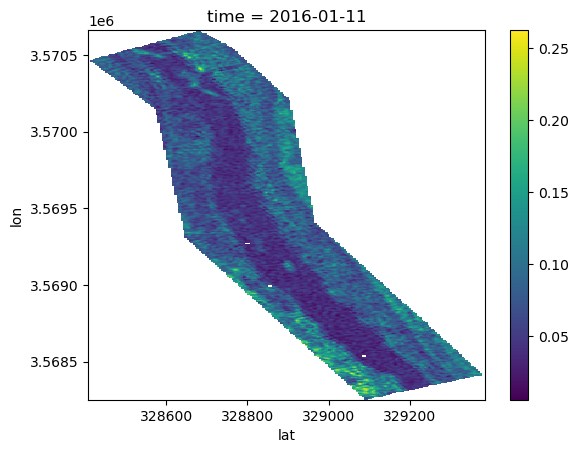

In [25]:
# Visualize the first timestep
data_xr2[0,:,:].plot()

This whole area is workshopping how to plot r2 in space

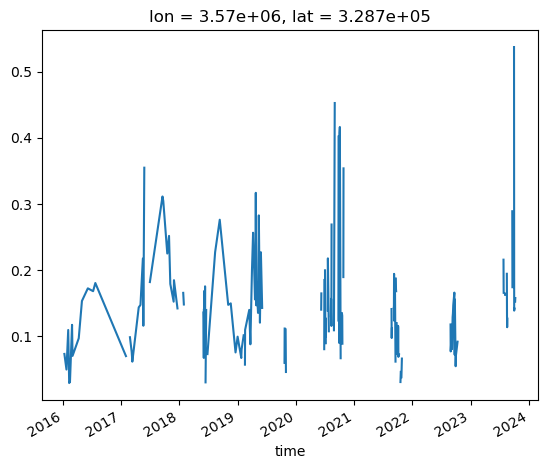

In [26]:
# Plotting the TS of a pixel
data_xr2[:,100,100].plot()

In [27]:
pixel = data_xr2[:,100,100].values
pixel.shape

(993,)

In [59]:
time = data_xr2['time'].values

In [60]:
time.shape

(993,)

In [61]:
data_test = data_xr2
data_test = data_test.rename('ndvi')
data_test

<xarray.DataArray 'ndvi' (time: 993, lon: 804, lat: 326)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-11 2016-01-24 ... 2023-10-08
  * lon      (lon) float64 3.571e+06 3.571e+06 3.571e+06 ... 3.568e+06 3.568e+06
  * lat      (lat) float64 3.284e+05 3.284e+05 3.284e+05 ... 3.294e+05 3.294e+05
Attributes:
    description:  Calculated NDVI

In [68]:
pixel = data_xr2[:,400,100].values
pixel.shape

(993,)

In [69]:
time = data_xr2['time'].values

In [70]:
# import scipy.stats as sp
df1 = time
df2 = pixel
y=np.array(df2, dtype=float)
x=np.array(pd.to_datetime(df1), dtype=float)
corr_coef = np.corrcoef(y, x)
corr_coef[0,1]
# pearsonr(x,y)

nan

This example was from chatgpt and it worked but it didn't ignore nans so basically everything was a nan

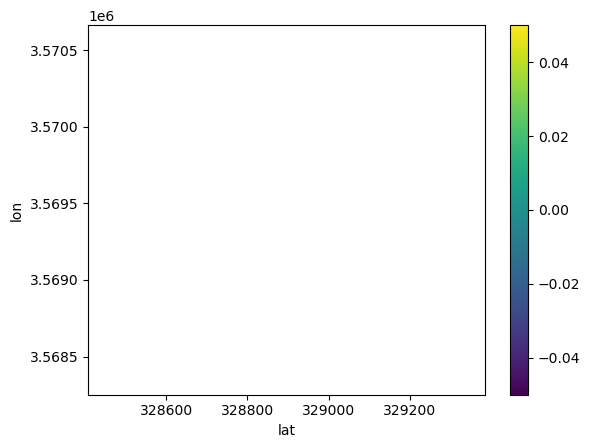

In [65]:
# # Example data
# time = pd.date_range('2023-01-01', '2023-01-10', freq='D')
# latitude = np.linspace(-90, 90, 10)
# longitude = np.linspace(0, 360, 20)

# # Create sample data with random values
# data = xr.DataArray(np.random.rand(len(time), len(latitude), len(longitude)),
#                     dims=('time', 'latitude', 'longitude'),
#                     coords={'time': time, 'latitude': latitude, 'longitude': longitude})
data = data_xr2

def correlation_coefficient(x, y):
    return np.corrcoef(x, y)[0, 1]

# Apply the correlation function along the 'time' dimension
correlation_result = xr.apply_ufunc(correlation_coefficient, data, data,
                                   input_core_dims=[['time'], ['time']],
                                   vectorize=True, dask='allowed')
correlation_result.plot()

This bit of code also ignores nans, I can't believe it worked

In [71]:
import xarray as xr
import numpy as np

# Assuming you have a 3D xarray DataArray named 'data' with dimensions ('time', 'latitude', 'longitude')

# Generate some example data
# data = xr.DataArray(np.random.rand(10, 3, 4), dims=('time', 'latitude', 'longitude'))
data = data_xr2

# Function to calculate correlation while ignoring NaN values
def corr_ignore_nan(x, y):
    valid_mask = ~np.isnan(x) & ~np.isnan(y)
    if np.sum(valid_mask) < 2:  # Not enough valid data points for correlation
        return np.nan
    else:
        return np.corrcoef(x[valid_mask], y[valid_mask])[0, 1]

# Use apply_ufunc to apply the correlation function along the 'time' dimension
correlation_result = xr.apply_ufunc(
    corr_ignore_nan,
    data,  # your 3D data
    data.time,  # you can choose another variable for correlation if needed
    input_core_dims=[['time'], ['time']],  # specify the core dimensions for each input
    vectorize=True,  # vectorize the function for better performance
    dask='parallelized',  # use parallelized computation if using dask arrays
    output_dtypes=[float]  # specify the output data type
)

# Print or use the result as needed
# print(correlation_result)


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[datetime64]'>)

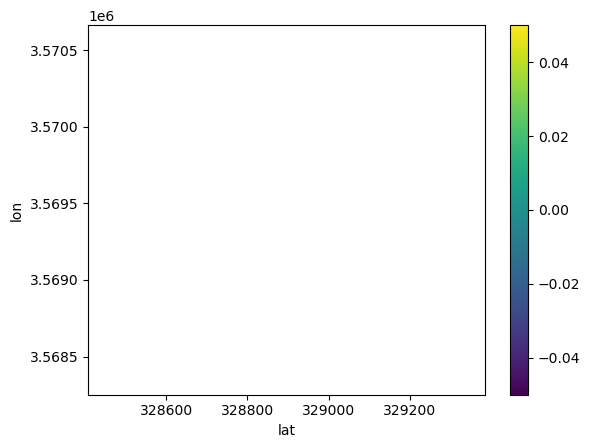

In [72]:
correlation_result.plot()

Comparing with the first timestep to see if it makes sense

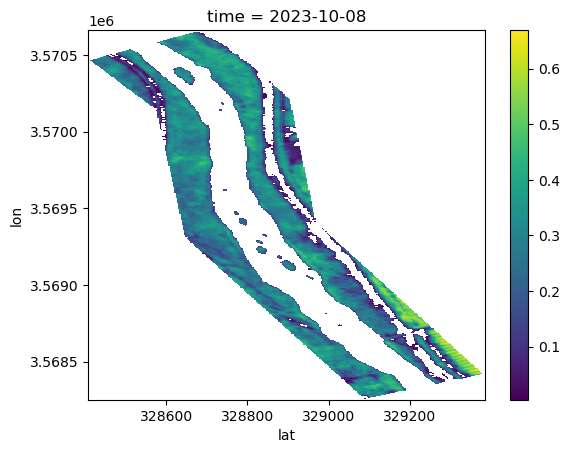

In [47]:
data_xr2[992,:,:].plot()

Clipping the weird bits

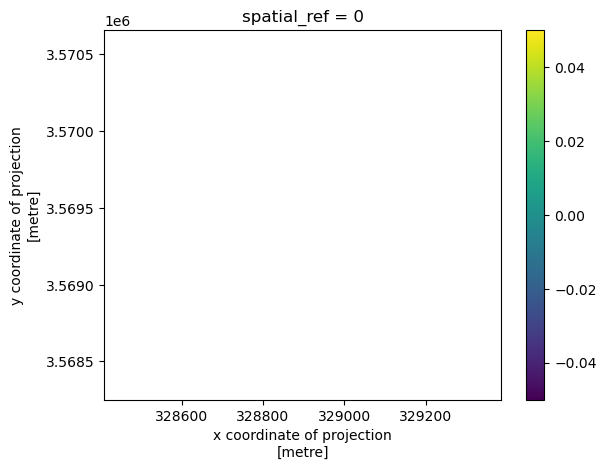

In [48]:
correlation_result = correlation_result.rio.set_spatial_dims('lat','lon')
correlation_result = correlation_result.rio.write_crs(32613)
correlation_result_clipped = correlation_result.rio.clip(mask_reproject.geometry, mask_reproject.crs)
correlation_result_clipped.plot()

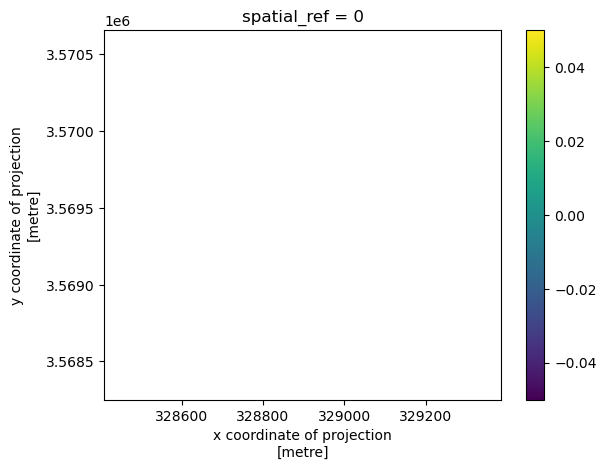

In [49]:
p_value = 2 * (1 - np.abs(correlation_result_clipped))  # Calculate p-value based on correlation coefficient

p_value = p_value.rio.set_spatial_dims('lat','lon')
p_value = p_value.rio.write_crs(32613)
p_value_clipped = p_value.rio.clip(mask_reproject.geometry, mask_reproject.crs)
p_value_clipped.plot()

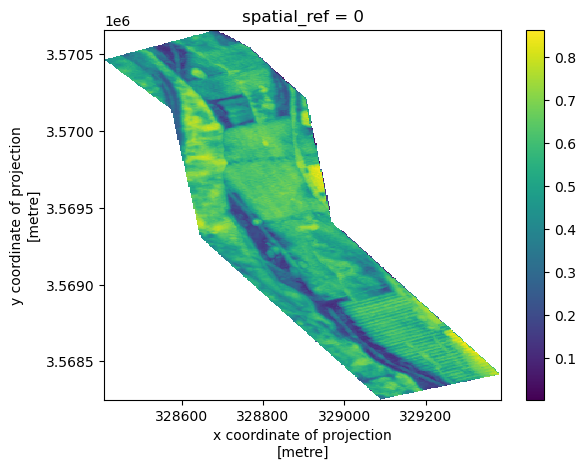

In [50]:
# Time Averaged Map

mean_ndvi_space = data_xr2.max(('time'))
mean_ndvi_space = mean_ndvi_space.rio.set_spatial_dims('lat','lon')
mean_ndvi_space = mean_ndvi_space.rio.write_crs(32613)
mean_ndvi_space_clipped = mean_ndvi_space.rio.clip(mask_reproject.geometry, mask_reproject.crs)
mean_ndvi_space_clipped.plot()

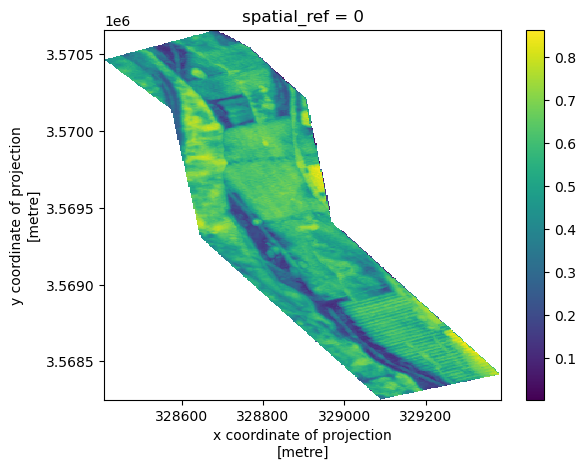

In [51]:
# Max NDVI per pixel Map

max_ndvi_space = data_xr2.max(('time'))
max_ndvi_space = max_ndvi_space.rio.set_spatial_dims('lat','lon')
max_ndvi_space = max_ndvi_space.rio.write_crs(32613)
max_ndvi_space_clipped = max_ndvi_space.rio.clip(mask_reproject.geometry, mask_reproject.crs)
max_ndvi_space_clipped.plot()

In [52]:
len(data_xr2[0,:,0])

804

In [53]:
for a in data_xr2[:,0,:]:
    for b in data_xr2[:,:,0]:
        pixel = data_xr2[:,b,a]
        time = data_xr2['time'].values
        df1 = time
        df2 = pixel
        y=np.array(df2, dtype=float)
        x=np.array(pd.to_datetime(df1), dtype=float)
        corr_coef = np.corrcoef(y, x)
        # print(corr_coef[0,1])
        pearsonr(x,y)


IndexError: arrays used as indices must be of integer (or boolean) type

In [54]:
from scipy.stats.stats import pearsonr

pearsonr(pixel,time)

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_3846/1105070959.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


UFuncTypeError: ufunc 'add' cannot use operands with types dtype('float64') and dtype('<M8[ns]')

In [194]:
import xskillscore as xs
r = xs.pearson_r(data_xr2,data_xr2.time,dim='time')
r

<xarray.DataArray (lon: 804, lat: 326)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 3.571e+06 3.571e+06 3.571e+06 ... 3.568e+06 3.568e+06
  * lat      (lat) float64 3.284e+05 3.284e+05 3.284e+05 ... 3.294e+05 3.294e+05

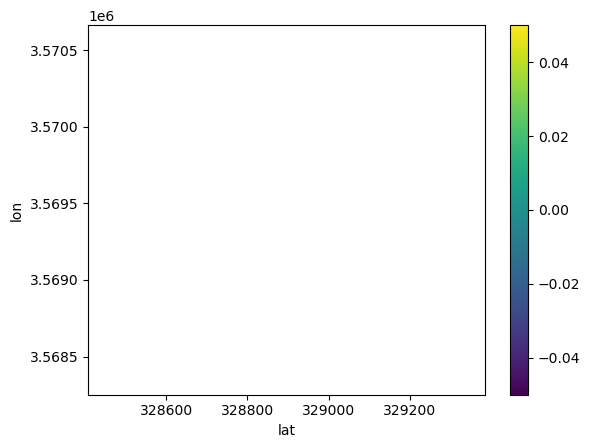

In [195]:
r.plot()

In [ ]:
# from Luis
import xskillscore as xs

def KGE_3D(sim, obs):
    #print(sim.shape)
    #print(obs.shape)
    alpha = sim.std(dim='time').to_numpy()/obs.std(dim='time').to_numpy()
    beta = sim.mean(dim='time').to_numpy()/obs.mean(dim='time').to_numpy()
    #corr_coeff = xs.pearson_r(sim.chunk({'time': -1}), obs.chunk({'time': -1}), dim='time')
    corr_coeff = xs.pearson_r(sim, obs, dim='time')
    corr_coeff = corr_coeff.isel(y=slice(0,1800))
    #print(alpha.shape)
    #print(beta.shape)
    #print(corr_coeff.shape)
    KGE = 1 - np.sqrt((corr_coeff-1)**2 + (alpha-1)**2 + (beta-1)**2 )
    return KGE, corr_coeff, alpha, beta

## Timeseries

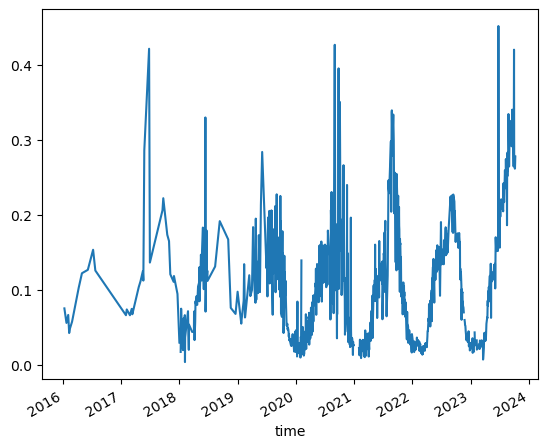

In [28]:
# Study area mean
NDVI_ts = data_xr2.mean(('lon','lat'))
NDVI_ts.plot()

In [29]:
NDVI_ts_df = NDVI_ts.to_dataframe(name='NDVI')
NDVI_ts_df['Year'] = pd.DatetimeIndex(NDVI_ts_df.index).year
NDVI_ts_df

,NDVI,Year
time,,
2016-01-11,0.075351,2016
2016-01-24,0.055947,2016
2016-02-04,0.066595,2016
2016-02-10,0.042501,2016
2016-02-15,0.048553,2016
...,...,...
2023-10-04,0.266081,2023
2023-10-05,0.261522,2023
2023-10-06,0.261847,2023


Text(0, 0.5, 'NDVI (-1 to 1)')

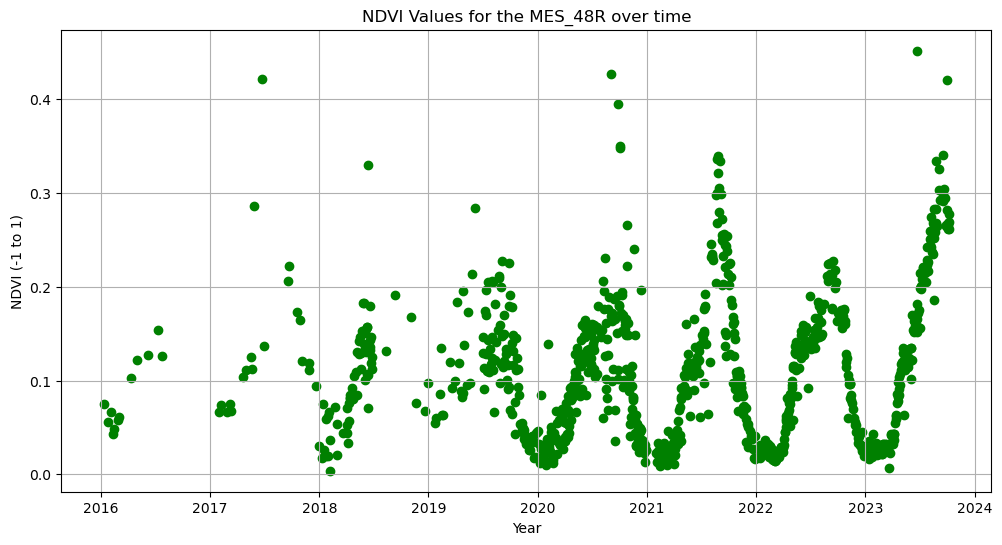

In [30]:
f, ax = plt.subplots(figsize=(12,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax.scatter(NDVI_ts_df.index, NDVI_ts_df['NDVI'], c='green')
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
ax.set(title="NDVI Values for the "+site_name+" over time")
# ax.legend(loc = 'upper right')
ax.grid(zorder = 0)
plt.xlabel('Year')
plt.ylabel('NDVI (-1 to 1)')

In [31]:
# Read in Erik's DTW Data (had to change from excel to csv)
head_rawdata = pd.read_csv('Data/EBID/MES_48R_DTW.csv')
head_rawdata

,DateTime,TOIC_Elevation,Benchmark_Elevation,Groundwater_Elevation,DTW_TOIC,DTW_Surface
0,8/19/09,3882.31,3881.2,3872.82,9.49,8.37
1,8/20/09,3882.31,3881.2,3872.91,9.40,8.28
2,8/21/09,3882.31,3881.2,3872.92,9.39,8.27
3,8/22/09,3882.31,3881.2,3873.07,9.24,8.13
4,8/23/09,3882.31,3881.2,3873.16,9.15,8.04
...,...,...,...,...,...,...
5043,7/24/23,3882.31,3881.2,"3,872.44",9.87,8.76
5044,7/25/23,3882.31,3881.2,"3,872.45",9.86,8.75
5045,7/26/23,3882.31,3881.2,"3,872.48",9.83,8.72
5046,7/27/23,3882.31,3881.2,"3,872.49",9.82,8.71


In [40]:
head = head_rawdata[['DateTime','DTW_TOIC','DTW_Surface']]
head.set_index("DateTime", inplace=True)
head.index = pd.to_datetime(head.index)
head = head.reset_index()
head.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5048 entries, 0 to 5047
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateTime     5048 non-null   datetime64[ns]
 1   DTW_TOIC     5042 non-null   float64       
 2   DTW_Surface  5042 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 118.4 KB


In [41]:
NDVI_ts_df_formerge = NDVI_ts_df.copy()
del NDVI_ts_df_formerge['Year']
NDVI_ts_df_formerge = NDVI_ts_df_formerge.reset_index()
NDVI_ts_df_formerge

,time,NDVI
0,2016-01-11,0.075351
1,2016-01-24,0.055947
2,2016-02-04,0.066595
3,2016-02-10,0.042501
4,2016-02-15,0.048553
...,...,...
988,2023-10-04,0.266081
989,2023-10-05,0.261522
990,2023-10-06,0.261847
991,2023-10-07,0.269153


In [42]:
NDVI_ts_df_formerge.rename(columns = {'time':'date'}, inplace=True)
head.rename(columns = {'DateTime':'date'}, inplace=True)

In [43]:
head_ndvi = NDVI_ts_df_formerge.merge(head, on=['date'],how='inner')

In [44]:
head_ndvi

,date,NDVI,DTW_TOIC,DTW_Surface
0,2016-01-11,0.075351,15.50,14.39
1,2016-01-24,0.055947,15.78,14.67
2,2016-02-04,0.066595,16.05,14.94
3,2016-02-10,0.042501,16.17,15.05
4,2016-02-15,0.048553,16.26,15.15
...,...,...,...,...
950,2023-07-24,0.204688,9.87,8.76
951,2023-07-25,0.228832,9.86,8.75
952,2023-07-26,0.242012,9.83,8.72
953,2023-07-27,0.222930,9.82,8.71


Text(0.5, 0, 'NDVI (full range -1 to 1)')

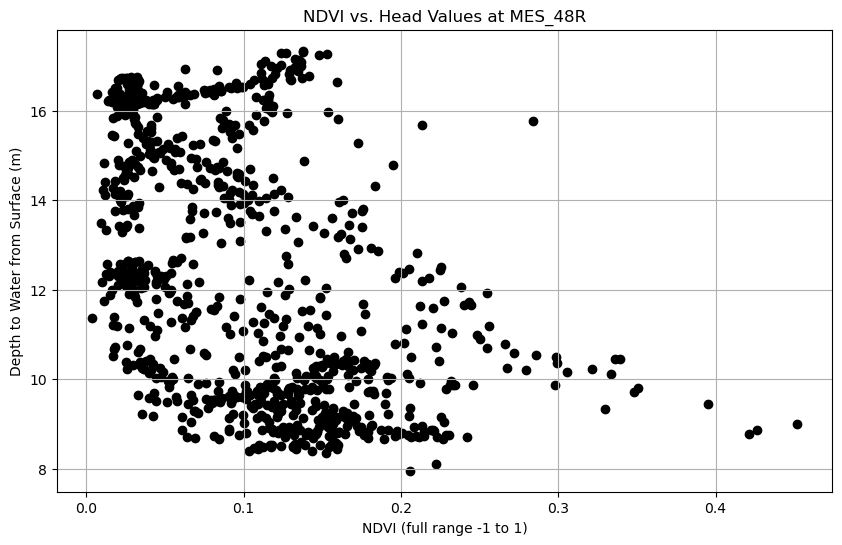

In [49]:
df = head_ndvi
f, ax = plt.subplots(figsize=(10,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax.scatter(df['NDVI'].values, df['DTW_Surface'].values, c='black',label = 'NDVI Range')
# ax.scatter(df['NDVI'].values, head_studyareas['Rin_2R'].values, c='black',label = 'NDVI Range')
# ax.scatter(df['NDVI'].values, head_studyareas['Rin_12R'].values, c='black',label = 'NDVI Range')
# ax2.hlines(y=0.113, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0.0915, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
ax.set(title="NDVI vs. Head Values at "+site_name)
# ax.set_xlim(0,0.5)
# ax.set_ylim(6,16)
# ax.legend(loc = 'lower left')
ax.grid(zorder = 0)
ax.set_ylabel('Depth to Water from Surface (m)')
ax.set_xlabel('NDVI (full range -1 to 1)')


Text(0.5, 0, 'Time')

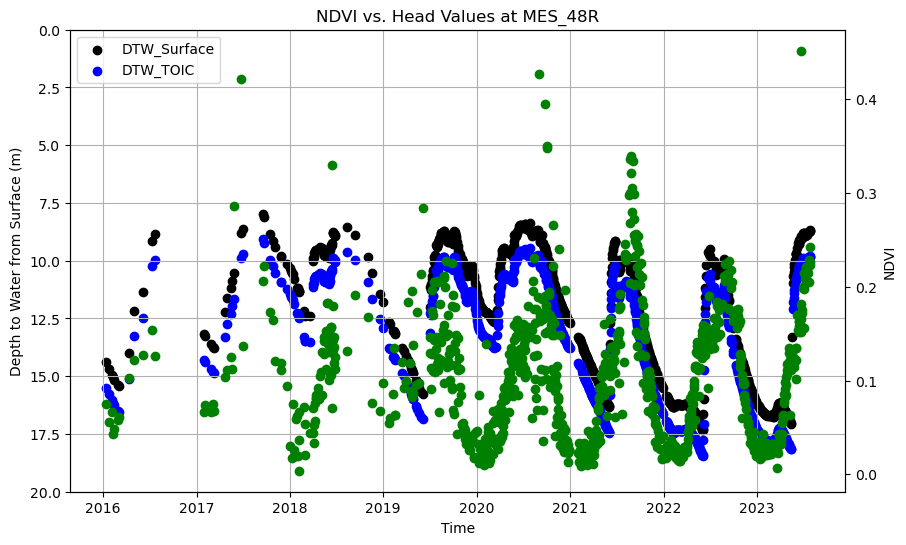

In [51]:
df = head_ndvi
f, ax = plt.subplots(figsize=(10,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax.scatter(df['date'].values, df['DTW_Surface'].values, c='black',label = 'DTW_Surface')
ax.scatter(df['date'].values, df['DTW_TOIC'].values, c='blue',label = 'DTW_TOIC')
# ax.scatter(df['NDVI'].values, head_studyareas['Rin_2R'].values, c='black',label = 'NDVI Range')
# ax.scatter(df['NDVI'].values, head_studyareas['Rin_12R'].values, c='black',label = 'NDVI Range')
# ax2.hlines(y=0.113, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0.0915, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
ax.set(title="NDVI vs. Head Values at "+site_name)
ax2 = ax.twinx()
ax2.scatter(df['date'].values,df['NDVI'].values, c='green',label='NDVI')
# ax.set_xlim(0,0.5)
ax.set_ylim(20,0)
ax.legend(loc = 'upper left')
ax.grid(zorder = 0)
ax.set_ylabel('Depth to Water from Surface (m)')
ax2.set_ylabel('NDVI')
ax.set_xlabel('Time')


In [56]:
# Define the path to the directory containing the .csv files
folder_path = 'Data/From_KC/RawGaugeData'

# List all .csv files in the directory
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Create an empty list to store individual DataFrames
dataframes = []

# Read each .csv file and append the DataFrame to the list
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    # Convert the 'date' column to datetime format
    if 'Reading' in df.columns:
        df['Reading'] = pd.to_datetime(df['Reading'])
    
    dataframes.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Display the combined DataFrame
combined_df

,Reading,Receive,Value,Unit,Data Quality
0,2022-12-31 23:33:39,2023-02-15 08:19:06,0.0,ft,A
1,2022-12-31 23:03:47,2023-02-15 08:19:06,0.0,ft,A
2,2022-12-31 22:33:47,2023-02-15 08:19:06,0.0,ft,A
3,2022-12-31 22:03:33,2023-02-15 08:19:06,0.0,ft,A
4,2022-12-31 21:33:09,2023-02-15 08:19:06,0.0,ft,A
...,...,...,...,...,...
131764,2016-01-01 02:07:03,2024-01-29 07:13:58,0.0,ft,A
131765,2016-01-01 01:36:47,2024-01-29 07:13:58,0.0,ft,A
131766,2016-01-01 01:06:44,2024-01-29 07:13:58,0.0,ft,A
131767,2016-01-01 00:36:49,2024-01-29 07:13:58,0.0,ft,A


In [58]:
combined_df['date'] = combined_df['Reading']
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131769 entries, 0 to 131768
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Reading       131769 non-null  datetime64[ns]
 1   Receive       131769 non-null  object        
 2   Value         131769 non-null  float64       
 3   Unit          131769 non-null  object        
 4   Data Quality  131769 non-null  object        
 5   date          131769 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 6.0+ MB


In [77]:
combined_df

,Reading,Receive,Value,Unit,Data Quality,date
0,2022-12-31 23:33:39,2023-02-15 08:19:06,0.0,ft,A,2022-12-31 23:33:39
1,2022-12-31 23:03:47,2023-02-15 08:19:06,0.0,ft,A,2022-12-31 23:03:47
2,2022-12-31 22:33:47,2023-02-15 08:19:06,0.0,ft,A,2022-12-31 22:33:47
3,2022-12-31 22:03:33,2023-02-15 08:19:06,0.0,ft,A,2022-12-31 22:03:33
4,2022-12-31 21:33:09,2023-02-15 08:19:06,0.0,ft,A,2022-12-31 21:33:09
...,...,...,...,...,...,...
131764,2016-01-01 02:07:03,2024-01-29 07:13:58,0.0,ft,A,2016-01-01 02:07:03
131765,2016-01-01 01:36:47,2024-01-29 07:13:58,0.0,ft,A,2016-01-01 01:36:47
131766,2016-01-01 01:06:44,2024-01-29 07:13:58,0.0,ft,A,2016-01-01 01:06:44
131767,2016-01-01 00:36:49,2024-01-29 07:13:58,0.0,ft,A,2016-01-01 00:36:49


/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_7862/4289047852.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_df = combined_df.groupby(combined_df['date'].dt.date).mean().reset_index()


<Axes: >

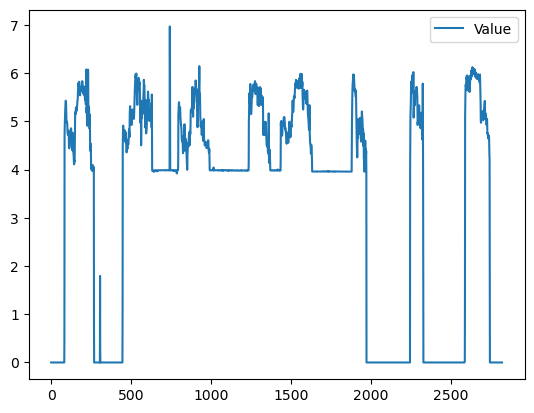

In [80]:
averaged_df = combined_df.groupby(combined_df['date'].dt.date).mean().reset_index()
averaged_df.plot()

In [85]:
averaged_df['date'] = pd.to_datetime(averaged_df['date'])
averaged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2822 non-null   datetime64[ns]
 1   Value   2822 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 44.2 KB


Text(0.5, 0, 'Time')

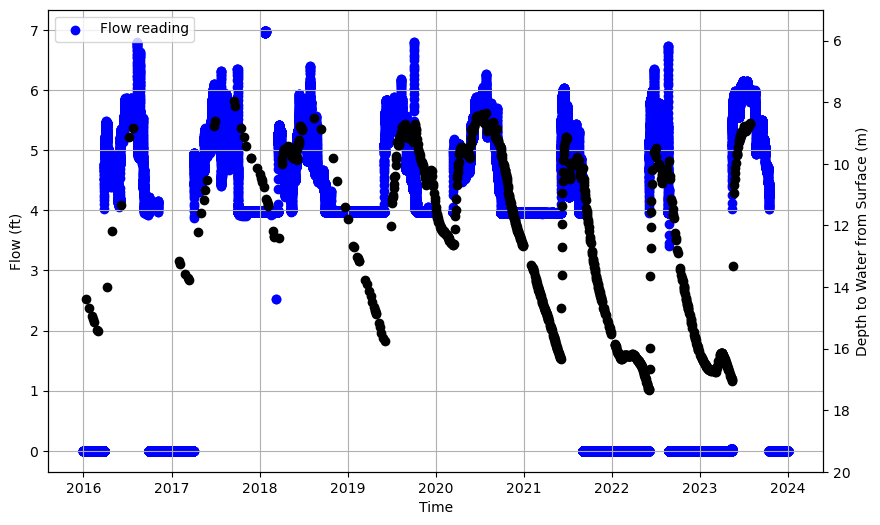

In [72]:
df = head_ndvi
f, ax = plt.subplots(figsize=(10,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax.scatter(combined_df['date'].values,combined_df['Value'].values, c='blue',label='Flow reading')
ax2 = ax.twinx()
ax2.scatter(df['date'].values, df['DTW_Surface'].values, c='black',label = 'DTW_Surface')
# ax.scatter(df['date'].values, df['DTW_TOIC'].values, c='blue',label = 'DTW_TOIC')
# ax.scatter(df['NDVI'].values, head_studyareas['Rin_2R'].values, c='black',label = 'NDVI Range')
# ax.scatter(df['NDVI'].values, head_studyareas['Rin_12R'].values, c='black',label = 'NDVI Range')
# ax2.hlines(y=0.113, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0.0915, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
# ax.set(title="NDVI vs. Head Values at "+site_name)
# ax.set_xlim(0,0.5)
ax2.set_ylim(20,5)
ax.legend(loc = 'upper left')
ax.grid(zorder = 0)
ax2.set_ylabel('Depth to Water from Surface (m)')
ax.set_ylabel('Flow (ft)')
ax.set_xlabel('Time')


In [110]:
head_ndvi_flow = averaged_df.merge(head_ndvi, on=['date'],how='right')
# head_ndvi_flow = pd.concat()
head_ndvi_flow

,date,Value,NDVI,DTW_TOIC,DTW_Surface
0,2016-01-11,0.000000,0.075351,15.50,14.39
1,2016-01-24,0.000000,0.055947,15.78,14.67
2,2016-02-04,0.000000,0.066595,16.05,14.94
3,2016-02-10,0.000000,0.042501,16.17,15.05
4,2016-02-15,0.000000,0.048553,16.26,15.15
...,...,...,...,...,...
950,2023-07-24,5.892917,0.204688,9.87,8.76
951,2023-07-25,5.904375,0.228832,9.86,8.75
952,2023-07-26,5.944792,0.242012,9.83,8.72
953,2023-07-27,5.953125,0.222930,9.82,8.71


Text(0.5, 0, 'Flow (ft)')

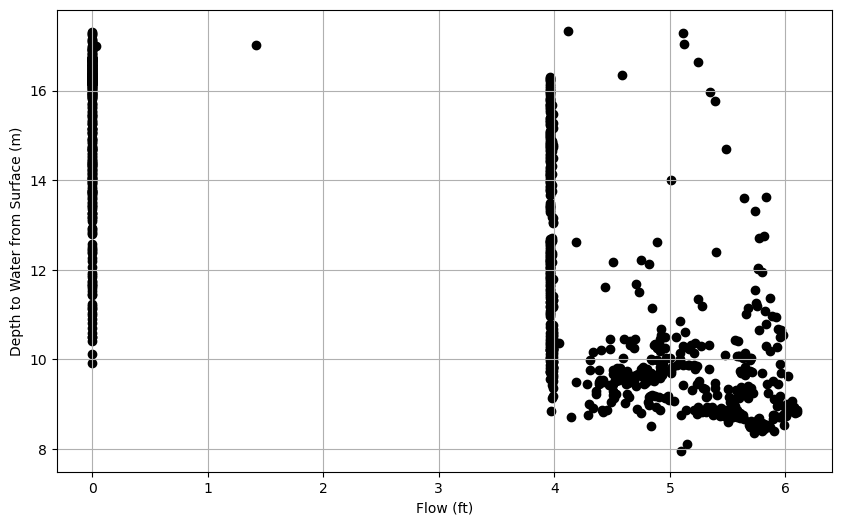

In [111]:
df = head_ndvi_flow
f, ax = plt.subplots(figsize=(10,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax.scatter(df['Value'].values, df['DTW_Surface'].values, c='black',label = 'DTW_Surface')
# ax.scatter(df['date'].values, df['DTW_TOIC'].values, c='blue',label = 'DTW_TOIC')
# ax.scatter(df['NDVI'].values, head_studyareas['Rin_2R'].values, c='black',label = 'NDVI Range')
# ax.scatter(df['NDVI'].values, head_studyareas['Rin_12R'].values, c='black',label = 'NDVI Range')
# ax2.hlines(y=0.113, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0.0915, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
# ax.set(title="NDVI vs. Head Values at "+site_name)
# ax.set_xlim(0,7)
# ax2.set_ylim(20,5)
# ax.legend(loc = 'upper left')
ax.grid(zorder = 0)
ax.set_ylabel('Depth to Water from Surface (m)')
ax.set_xlabel('Flow (ft)')


In [112]:
df = head_ndvi_flow
# Set 'date' as the index
df.set_index('date', inplace=True)

# Resample by year and calculate the mean
resample_df = df.resample('Y').mean()

# Reset index to get 'date' back as a column
resample_df.reset_index(inplace=True)
resample_df

,date,Value,NDVI,DTW_TOIC,DTW_Surface
0,2016-12-31,2.167396,0.086538,14.490000,13.377500
1,2017-12-31,3.505017,0.142798,11.837000,10.727000
2,2018-12-31,4.720348,0.101666,11.027302,9.912381
3,2019-12-31,4.606419,0.111814,11.750377,10.640377
4,2020-12-31,4.694737,0.098948,11.622664,10.508079
5,2021-12-31,2.786508,0.109813,14.396238,13.282277
6,2022-12-31,0.961711,0.090941,15.885612,14.775612
7,2023-12-31,2.040405,0.093951,15.224160,14.114160


Text(0.5, 0, 'Flow (ft)')

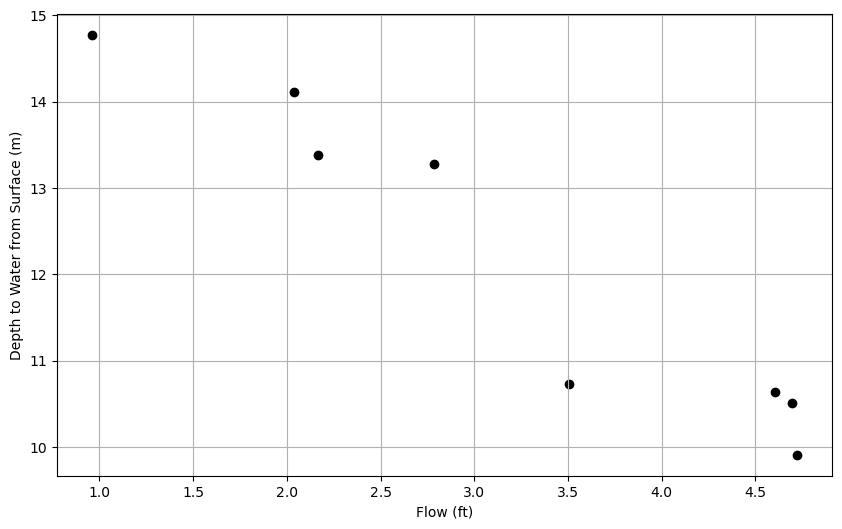

In [113]:
df = resample_df
f, ax = plt.subplots(figsize=(10,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax.scatter(df['Value'].values, df['DTW_Surface'].values, c='black',label = 'DTW_Surface')
# ax.scatter(df['date'].values, df['DTW_TOIC'].values, c='blue',label = 'DTW_TOIC')
# ax.scatter(df['NDVI'].values, head_studyareas['Rin_2R'].values, c='black',label = 'NDVI Range')
# ax.scatter(df['NDVI'].values, head_studyareas['Rin_12R'].values, c='black',label = 'NDVI Range')
# ax2.hlines(y=0.113, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0.0915, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
# ax.set(title="NDVI vs. Head Values at "+site_name)
# ax.set_xlim(0,7)
# ax2.set_ylim(20,5)
# ax.legend(loc = 'upper left')
ax.grid(zorder = 0)
ax.set_ylabel('Depth to Water from Surface (m)')
ax.set_xlabel('Flow (ft)')


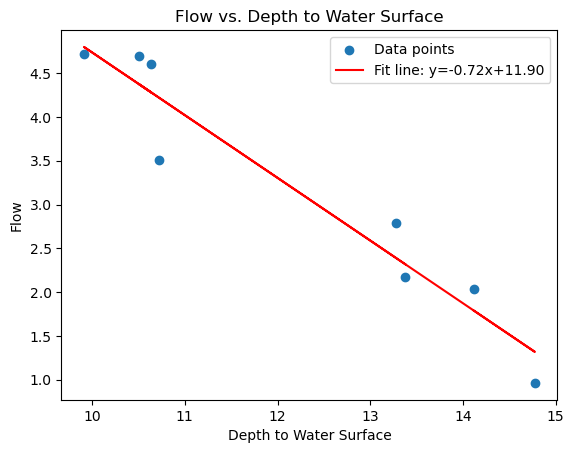

Linear regression equation: y = -0.72x + 11.90


In [114]:
from scipy.stats import linregress

df = resample_df
# Scatterplot data
x = df['DTW_Surface']
y = df['Value']

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create regression line
regression_line = slope * x + intercept

# Plot scatterplot
plt.scatter(x, y, label='Data points')

# Plot regression line
plt.plot(x, regression_line, color='red', label=f'Fit line: y={slope:.2f}x+{intercept:.2f}')

# Add title and labels
plt.title('Flow vs. Depth to Water Surface')
plt.xlabel('Depth to Water Surface')
plt.ylabel('Flow')

# Display regression equation on plot
plt.legend()

# Show plot
plt.show()

# Print regression equation
print(f'Linear regression equation: y = {slope:.2f}x + {intercept:.2f}')

In [49]:
# Reading in KC's data
seepage = pd.read_csv('Data/From_KC/Flow_values.csv')
seepage

,Monitoring station,Rin_10R,Rin_1R,Rin_11R,Rin_9R,Rin_2R,Rin_8R,Rin_3R,Rin_7R,Rin_4R,Rin_5R,Rin_12R,Rin_6R,Rin_13R,Mean,Sum,Std dev
0,2010.0,0.040,0.016,0.021,-0.001,0.001,0.035,0.020,0.030,0.014,0.019,0.003,-0.018,0.000,0.012,0.141,0.014
1,2011.0,0.054,0.039,0.061,0.059,0.046,0.049,0.044,0.050,0.035,0.024,0.033,0.007,0.004,0.038,0.451,0.018
2,2012.0,0.101,0.089,0.113,0.113,0.113,0.061,0.096,0.082,0.081,0.056,0.074,0.035,0.031,0.079,0.944,0.027
3,2013.0,0.058,0.064,0.098,0.113,0.080,0.045,0.063,0.053,0.058,0.042,0.072,0.016,0.034,0.061,0.737,0.026
4,2014.0,0.074,0.087,0.113,0.113,0.097,0.063,0.093,0.075,0.090,0.061,0.113,0.024,0.042,0.081,0.972,0.028
5,2015.0,0.050,0.055,0.088,0.109,0.056,0.036,0.063,0.045,0.060,0.037,0.083,0.014,0.025,0.056,0.672,0.026
6,2016.0,0.092,0.099,0.113,0.113,0.095,0.056,0.096,0.067,0.091,0.062,0.082,0.012,0.048,0.078,0.935,0.029
7,2017.0,0.052,0.045,0.065,0.089,0.042,0.020,0.034,0.053,0.044,0.035,0.011,-0.016,0.027,0.037,0.449,0.025
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
head = pd.read_csv('Data/From_KC/Groundwater_head_values.csv')
head

,Monitoring station,Rin_10R,Rin_1R,Rin_11R,Rin_9R,Rin_2R,Rin_8R,Rin_3R,Rin_7R,Rin_4R,Rin_5R,Rin_12R,Rin_6R,Rin_13R,Mean,Sum,Std dev
0,2010,0.859,1.015,1.772,0.771,1.101,1.003,1.242,1.366,1.803,1.621,2.548,2.345,2.014,1.550,18.601,0.539
1,2011,0.466,0.548,0.982,-0.289,0.287,0.620,0.751,0.897,1.380,1.465,2.005,1.967,1.948,1.047,12.559,0.693
2,2012,0.139,0.109,0.181,-0.341,-0.341,0.722,0.300,0.753,0.970,1.177,1.647,1.642,1.616,0.703,8.434,0.699
3,2013,0.095,-0.223,-0.178,-0.341,-0.341,0.470,0.085,0.587,0.684,0.936,0.941,1.706,1.228,0.463,5.554,0.643
4,2014,0.017,-0.341,-0.341,-0.341,-0.341,0.296,-0.248,0.357,0.280,0.727,-0.026,1.623,1.213,0.238,2.857,0.631
5,2015,0.132,-0.181,-0.199,-0.341,-0.317,0.558,-0.105,0.648,0.454,0.936,0.440,1.729,1.365,0.416,4.987,0.651
6,2016,0.364,0.104,0.543,-0.341,0.019,0.855,0.422,1.022,0.960,1.184,1.645,1.948,1.458,0.818,9.818,0.664
7,2017,0.694,0.604,1.166,-0.341,0.533,1.223,1.055,1.055,1.385,1.402,2.440,2.305,1.630,1.205,14.458,0.721


In [146]:
# Case study stations
seepage_studyareas = seepage[['Monitoring station','Rin_11R','Rin_2R','Rin_12R']]

head_studyareas = head[['Monitoring station','Rin_11R','Rin_2R','Rin_12R']]
head_studyareas

,Monitoring station,Rin_11R,Rin_2R,Rin_12R
0,2010,1.772,1.101,2.548
1,2011,0.982,0.287,2.005
2,2012,0.181,-0.341,1.647
3,2013,-0.178,-0.341,0.941
4,2014,-0.341,-0.341,-0.026
5,2015,-0.199,-0.317,0.440
6,2016,0.543,0.019,1.645
7,2017,1.166,0.533,2.440


In [147]:
seepage_studyareas = seepage_studyareas.rename(columns= {'Monitoring station':'Year'})
head_studyareas = head_studyareas.rename(columns= {'Monitoring station':'Year'})
seepage_studyareas = seepage_studyareas.set_index('Year')
head_studyareas = head_studyareas.set_index('Year')
head_studyareas

,Rin_11R,Rin_2R,Rin_12R
Year,,,
2010,1.772,1.101,2.548
2011,0.982,0.287,2.005
2012,0.181,-0.341,1.647
2013,-0.178,-0.341,0.941
2014,-0.341,-0.341,-0.026
2015,-0.199,-0.317,0.440
2016,0.543,0.019,1.645
2017,1.166,0.533,2.440


In [122]:
# NDVI_ts_df = NDVI_ts_df.set_index('Year')
NDVI_ts_df
NDVI_df_year_min = pd.pivot_table(NDVI_ts_df, index=["Year"], values=['NDVI'], dropna=False, aggfunc=np.min)
NDVI_df_year_max = pd.pivot_table(NDVI_ts_df, index=["Year"], values=['NDVI'], dropna=False, aggfunc=np.max)
NDVI_df_year_mean = pd.pivot_table(NDVI_ts_df, index=["Year"], values=['NDVI'], dropna=False, aggfunc=np.mean)

NDVI_df_year_max

,NDVI
Year,
2010,0.180760
2012,0.114276
2013,0.150722
2014,0.144066
2015,0.077225
2016,0.089095
2017,0.118029


Text(0, 0.5, 'Net Annual Pressure Head (m)')

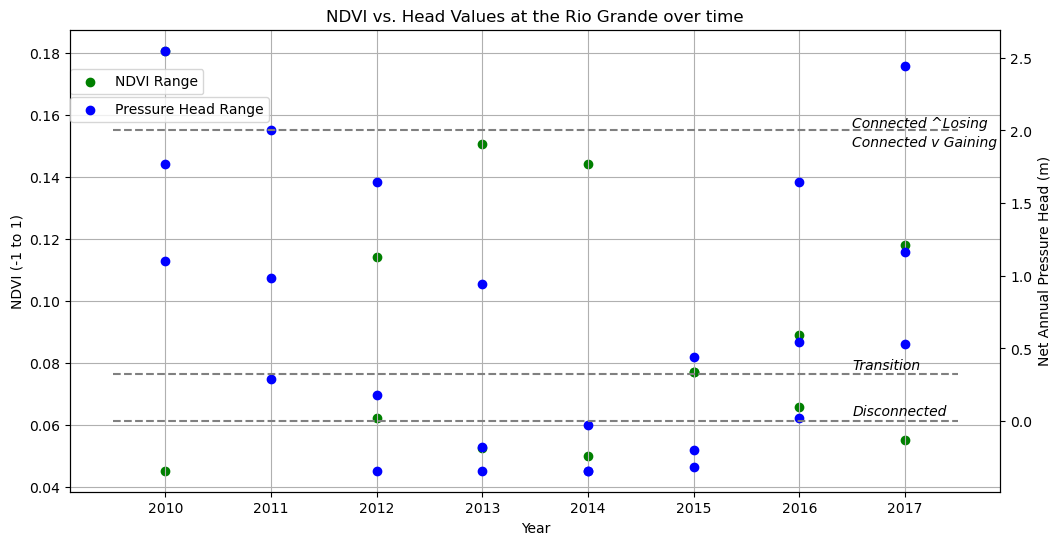

In [216]:
f, ax = plt.subplots(figsize=(12,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax2 = ax.twinx()
ax2.scatter(head_studyareas.index, head_studyareas['Rin_11R'], c='blue', label = 'Pressure Head Range')
ax2.scatter(head_studyareas.index, head_studyareas['Rin_2R'], c='blue')
ax2.scatter(head_studyareas.index, head_studyareas['Rin_12R'], c='blue')
ax.scatter(NDVI_df_year_max.index, NDVI_df_year_max['NDVI'], c='green',label = 'NDVI Range')
ax.scatter(NDVI_df_year_min.index, NDVI_df_year_min['NDVI'], c='green')
ax2.hlines(y=2.0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax2.hlines(y=0.325, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax.text(2016.5, 0.156, 'Connected ^Losing', style='italic', bbox={
        'facecolor': 'white', 'alpha': 0, 'pad': 5})
ax.text(2016.5, 0.150, 'Connected v Gaining', style='italic', bbox={
        'facecolor': 'white', 'alpha': 0, 'pad': 5})
ax.text(2016.5, 0.078, 'Transition', style='oblique', bbox={
        'facecolor': 'white', 'alpha': 0.0, 'pad': 5})
ax.text(2016.5, 0.063, 'Disconnected', style='oblique', bbox={
        'facecolor': 'white', 'alpha': 0, 'pad': 5})
ax.set(title="NDVI vs. Head Values at the Rio Grande over time")
ax.legend(loc = [0,0.86])
ax2.legend(loc = [0,0.8])
ax.grid(zorder = 0)
ax.set_xlabel('Year')
ax.set_ylabel('NDVI (-1 to 1)')
ax2.set_ylabel('Net Annual Pressure Head (m)')

Text(0, 0.5, 'Seepage Flow (cms)')

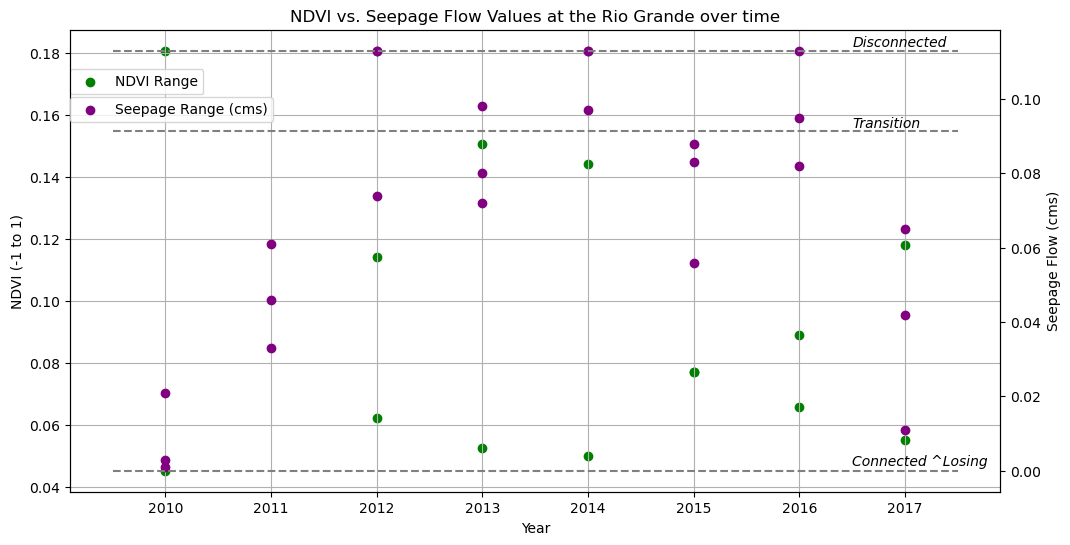

In [210]:
f, ax = plt.subplots(figsize=(12,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax2 = ax.twinx()
ax2.scatter(seepage_studyareas.index, seepage_studyareas['Rin_11R'], c='purple', label = 'Seepage Range (cms)')
ax2.scatter(seepage_studyareas.index, seepage_studyareas['Rin_2R'], c='purple')
ax2.scatter(seepage_studyareas.index, seepage_studyareas['Rin_12R'], c='purple')
ax.scatter(NDVI_df_year_max.index, NDVI_df_year_max['NDVI'], c='green',label = 'NDVI Range')
ax.scatter(NDVI_df_year_min.index, NDVI_df_year_min['NDVI'], c='green')
ax2.hlines(y=0.113, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax2.hlines(y=0.0914, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax.text(2016.5, 0.047, 'Connected ^Losing', style='italic', bbox={
        'facecolor': 'white', 'alpha': 0, 'pad': 5})
ax.text(2016.5, 0.156, 'Transition', style='oblique', bbox={
        'facecolor': 'white', 'alpha': 0.0, 'pad': 5})
ax.text(2016.5, 0.182, 'Disconnected', style='oblique', bbox={
        'facecolor': 'white', 'alpha': 0, 'pad': 5})
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
ax.set(title="NDVI vs. Seepage Flow Values at the Rio Grande over time")
ax.legend(loc = [0,0.86])
ax2.legend(loc = [0,0.8])
ax.grid(zorder = 0)
ax.set_xlabel('Year')
ax.set_ylabel('NDVI (-1 to 1)')
ax2.set_ylabel('Seepage Flow (cms)')

In [129]:
NDVI_DF2 = NDVI_df_year_mean.reset_index()
# NDVI_DF2 = NDVI_DF2.append([2011,np.nan])

df = NDVI_DF2.append({'Year':2011, 'NDVI':np.nan}, ignore_index=True)
df

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_3184/3983479622.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = NDVI_DF2.append({'Year':2011, 'NDVI':np.nan}, ignore_index=True)


,Year,NDVI
0,2010.0,0.098050
1,2012.0,0.088233
2,2013.0,0.081068
3,2014.0,0.079872
4,2015.0,0.077225
5,2016.0,0.080045
6,2017.0,0.089396
7,2011.0,NaN


Text(0.5, 0, 'NDVI (-1 to 1)')

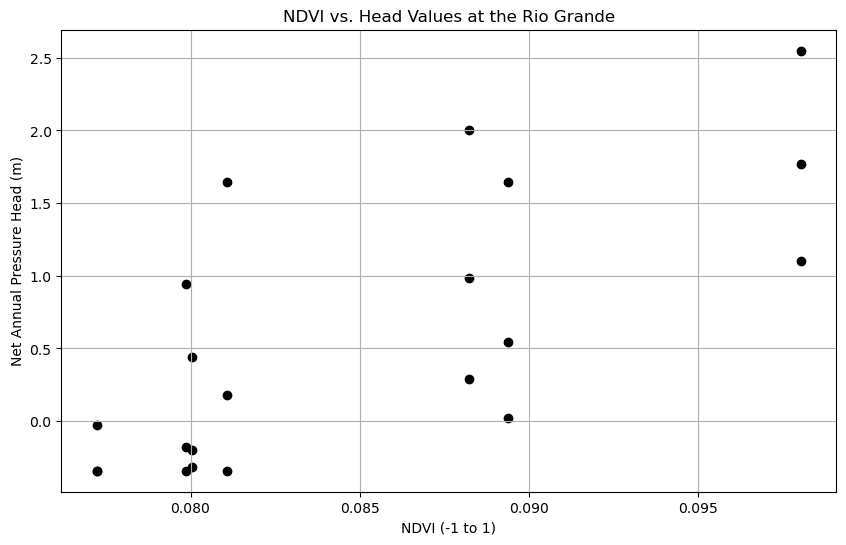

In [152]:
f, ax = plt.subplots(figsize=(10,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax.scatter(df['NDVI'].values, head_studyareas['Rin_11R'].values, c='black',label = 'NDVI Range')
ax.scatter(df['NDVI'].values, head_studyareas['Rin_2R'].values, c='black',label = 'NDVI Range')
ax.scatter(df['NDVI'].values, head_studyareas['Rin_12R'].values, c='black',label = 'NDVI Range')
# ax2.hlines(y=0.113, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0.0915, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
ax.set(title="NDVI vs. Head Values at the Rio Grande")
# ax.legend(loc = 'lower left')
ax.grid(zorder = 0)
ax.set_ylabel('Net Annual Pressure Head (m)')
ax.set_xlabel('NDVI (-1 to 1)')


In [148]:
# y = seepage_studyareas['Rin_11R'].values
y = seepage_studyareas.iloc[:-1,:]
y

,Rin_11R,Rin_2R,Rin_12R
Year,,,
2010.0,0.021,0.001,0.003
2011.0,0.061,0.046,0.033
2012.0,0.113,0.113,0.074
2013.0,0.098,0.080,0.072
2014.0,0.113,0.097,0.113
2015.0,0.088,0.056,0.083
2016.0,0.113,0.095,0.082
2017.0,0.065,0.042,0.011


Text(0.5, 0, 'NDVI (-1 to 1)')

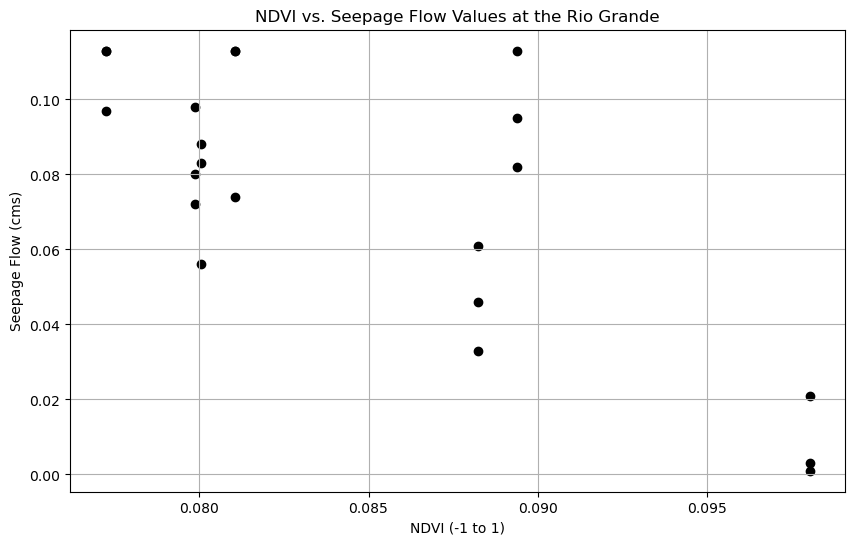

In [151]:
f, ax = plt.subplots(figsize=(10,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax.scatter(df['NDVI'].values, y['Rin_11R'].values, c='black',label = 'NDVI Range')
ax.scatter(df['NDVI'].values, y['Rin_2R'].values, c='black',label = 'NDVI Range')
ax.scatter(df['NDVI'].values, y['Rin_12R'].values, c='black',label = 'NDVI Range')
# ax2.hlines(y=0.113, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0.0915, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
ax.set(title="NDVI vs. Seepage Flow Values at the Rio Grande")
# ax.legend(loc = 'lower left')
ax.grid(zorder = 0)
ax.set_ylabel('Seepage Flow (cms)')
ax.set_xlabel('NDVI (-1 to 1)')
